

# Notebook - LOS EMBEDDINGS COMO REPRESENTACIÒN DE TEXTOS EN NN, RNN y LSTM". **Caso Uso Nºx**

# Ejemplo de uso de Embeddings

Este Caso de Uso tiene por finalidad realizar un ejemplo que no sea NLP utilizando Embeddings con Keras

***REF:***

- Unipython (2019). EL MODELO EMBEDDINGS (INCRUSTACIONES) DE PALABRAS. https://unipython.com/el-modelo-embeddings-incrustaciones-de-palabras/

# **INTRODUCCIÓN**

- Las embeddings de palabras, o incrustaciones de palabras son un tipo de representación de palabras, que permite que ciertas palabras con significado similar tengan una representación similar.

- Son una representación distribuida de texto, que es quizás uno de los avances clave para el impresionante rendimiento de los métodos de Deep Learning en el desafío de los problemas de procesamiento del lenguaje natural

***¿Qué son las embeddings de palabras?***

- Una embedding de palabras es una representación aprendida de un texto, donde las palabras que tienen el mismo significado tienen una representación similar. Este enfoque de la representación de palabras y documentos puede ser considerado como uno de los principales avances del Deep Learning en los problemas de procesamiento del lenguaje natural.

- Las embeddings de palabras son, de hecho, una clase de técnicas en las que las palabras individuales se representan como vectores de valor real en un espacio vectorial predefinido. Cada palabra se mapea a un vector y los valores vectoriales se aprenden de una manera que se asemejan a los de un vector.

- La clave del enfoque es la idea de usar una representación distribuida densa para cada palabra. Cada palabra está representada por un vector de valor real, a menudo decenas o cientos de dimensiones. Esto contrasta con las miles o millones de dimensiones requeridas para representaciones de palabras escasas, tales como una codificación en caliente.

- La representación distribuida se aprende a partir del uso de las palabras. Esto permite que palabras que son usadas de maneras similares resulten en representaciones similares, capturando naturalmente su significado. Esto puede contrastarse con la representación nítida pero frágil de un modelo de bolsa de palabras** ("Bag Words")** en el que, a menos que se maneje explícitamente, las diferentes palabras tienen diferentes representaciones, independientemente de cómo se utilicen.

- Hay una teoría lingüística más profunda detrás del enfoque como la hipótesis distribucional de Zellig Harris que podría resumirse como: *las palabras que tienen un contexto similar, tendrán significados similares.*



## Importamos librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam

## Creamos una serie temporal Fake

La idea del ejercicio será comparar el uso de valores categóricos "simples" <br>y ver cuánto mejoran con embeddings (o no)

In [2]:
ventas_falsas=pd.DataFrame()

anio=[]
mes=[]
dias=[]
vtas=[]
clientes=[]
cliente=1000
for a in range(1,5):
    for m in range(1,13):
        for i in range(0,30):
            anio.append(a)
            mes.append(m)
            dias.append(i%7)
            cliente = (cliente/3) + (i+1+(m*2)+(a*2))
            clientes.append(cliente)
            if i==0:
                vtas.append(0.0) # los domingos esta cerrado
            else:
                if m<4:
                    dinero = ((i%7) * cliente * 5)
                if m<8:
                    dinero = ((i%7) * cliente * 15)
                else:
                    dinero = ((i%7) * cliente * 25)
                if(i==5):
                    dinero = dinero*1.25 #los viernes vende mas
                if(i==3):
                    dinero = dinero*0.75 #los miercoles vende menos
                vtas.append(dinero)

ventas_falsas['anio']=anio
ventas_falsas['mes']=mes
ventas_falsas['dia']=dias
ventas_falsas['clientes']=clientes
ventas_falsas['ventas']=vtas

ventas_falsas.head()

,anio,mes,dia,clientes,ventas
0,1,1,0,338.333333,0.000000
1,1,1,1,118.777778,1781.666667
2,1,1,2,46.592593,1397.777778
3,1,1,3,23.530864,794.166667
4,1,1,4,16.843621,1010.617284


In [3]:
# Normalización de los datos de la Serie de Tiempo

# prepare data for normalization
values = ventas_falsas['ventas'].values
values = values.reshape((len(values), 1))

# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)

print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))

# normalize the dataset and print the first 5 rows
normalized = scaler.transform(values)

for i in range(5):
    print(normalized[i])

# inverse transform and print the first 5 rows
inversed = scaler.inverse_transform(normalized)

for i in range(5):
    print(inversed[i])


Min: 0.000000, Max: 13387.500000
[0.]
[0.13308434]
[0.10440917]
[0.05932151]
[0.07548962]
[0.]
[1781.66666667]
[1397.77777778]
[794.16666667]
[1010.61728395]


In [4]:
values2 = ventas_falsas['clientes'].values
values2 = values2.reshape((len(values), 1))

# train the normalization
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler2 = scaler2.fit(values2)

print('Min: %f, Max: %f' % (scaler2.data_min_, scaler2.data_max_))

# normalize the dataset and print the first 5 rows
normalized2 = scaler2.transform(values2)

ventas_falsas['clientes']=normalized2
ventas_falsas['ventas']=normalized

training_data=ventas_falsas.drop(['ventas'],1)
target_data=ventas_falsas['ventas']

ventas_falsas.head()

Min: 14.305556, Max: 338.333333


<ipython-input-4-639b5cb111bb>:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  training_data=ventas_falsas.drop(['ventas'],1)


,anio,mes,dia,clientes,ventas
0,1,1,0,1.000000,0.000000
1,1,1,1,0.322417,0.133084
2,1,1,2,0.099643,0.104409
3,1,1,3,0.028471,0.059322
4,1,1,4,0.007833,0.075490


<Axes: >

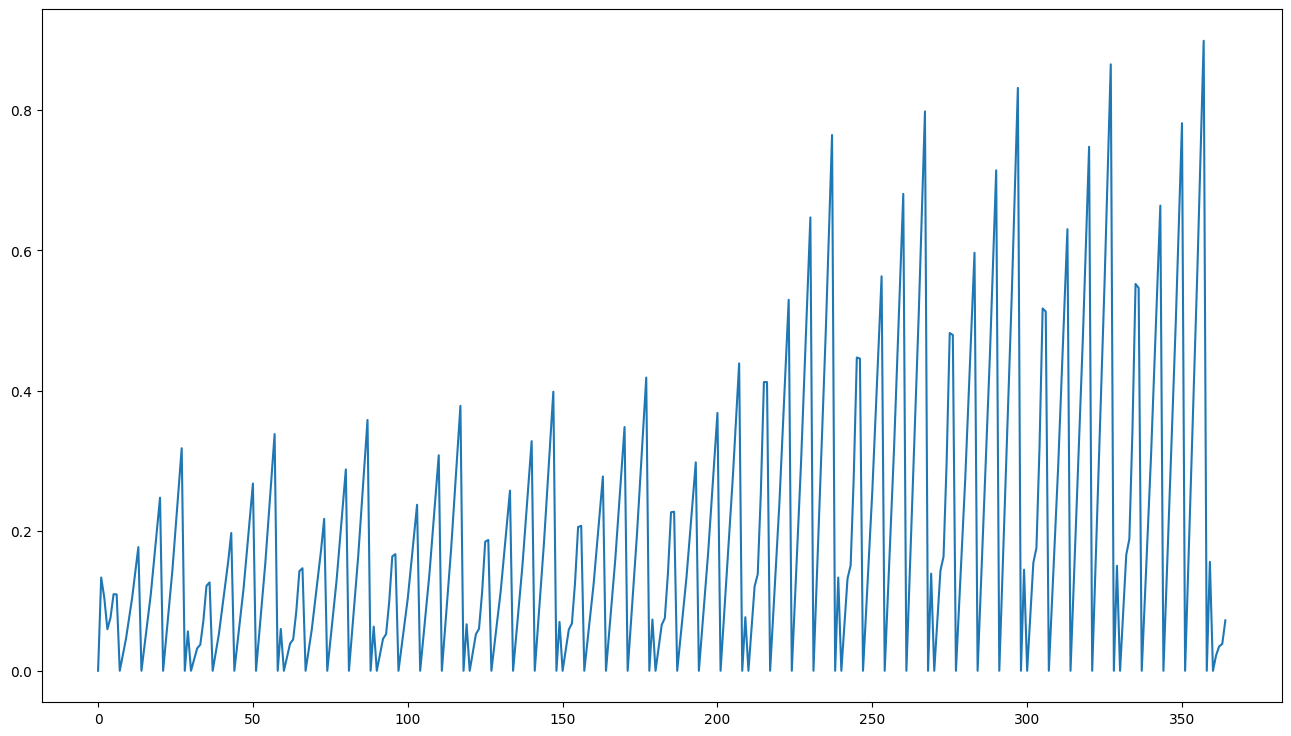

In [5]:
ventas_falsas['ventas'][0:365].plot() # Visualizamos el 1er anio

#ventas_falsas['ventas'][366:365*2].plot()
#ventas_falsas['ventas'][366+366:365*3].plot()

***OBJETIVO:***

- Ver la predicción con una red neuronal normal usando semana como categ.<br>
y ver con otra red pero con Embeddings, si mejora.

## Parametros

In [6]:
#Configuraciones generales

EPOCHS=50
dense_n = 20
cuantos=250       #para graficar
fun_act='sigmoid' #Probado también con tanh relu

## Subdividimos el Set en entrenamiento y Validación

In [7]:
training_data.shape

(1440, 4)

In [8]:
valid_data = training_data[1000:1440]
valid_target=target_data[1000:1440]
valid_target.shape

(440,)

In [9]:
training_data = training_data[0:1000]
target_data=target_data[0:1000]
target_data.shape

(1000,)

# 1 -Red Neuronal - Sin Embeddings

Creamos una red neuronal de una capa para predecir precios

In [10]:
model0 = Sequential()
model0.add(Dense(dense_n, input_dim=4, activation=fun_act))
model0.add(Dense(1, activation=fun_act))

model0.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])

model0.summary()

history=model0.fit(training_data, target_data, epochs=EPOCHS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                100       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 121 (484.00 Byte)
Trainable params: 121 (484.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
32/32 [==============================] - 5s 3ms/step - loss: 0.0591 - MSE: 0.0591
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0429 - MSE: 0.0429
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0387 - MSE: 0.0387
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0366 - MSE: 0.0366
Epoch 5/50
32/32 [========================

In [11]:
# evaluamos el modelo
scores = model0.evaluate(training_data, target_data)
print("\n%s: %.4f" % (model0.metrics_names[1], scores[1]))

scores = model0.evaluate(valid_data, valid_target)
print("\n%s: %.4f" % (model0.metrics_names[1], scores[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.0058 - MSE: 0.0058

MSE: 0.0058
14/14 [==============================] - 0s 2ms/step - loss: 0.0125 - MSE: 0.0125

MSE: 0.0125


14/14 [==============================] - 0s 2ms/step
440


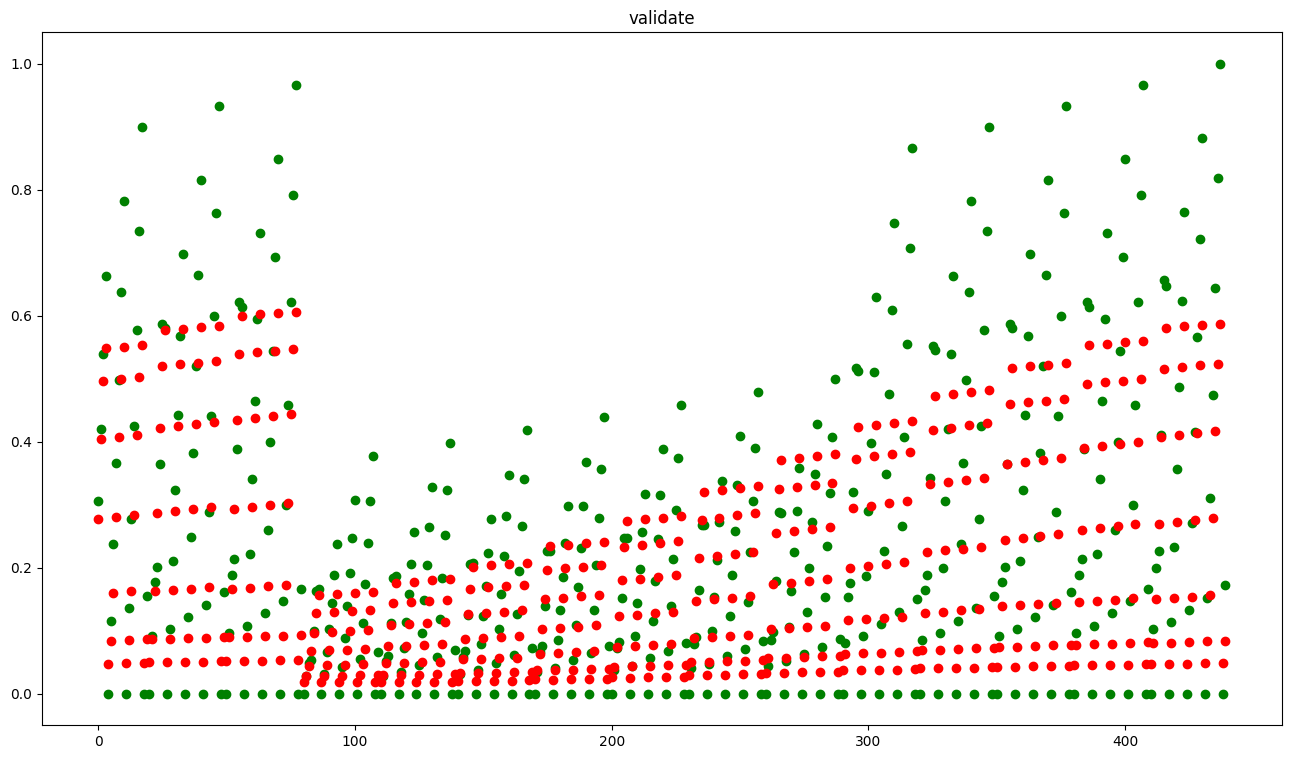

In [12]:
results=model0.predict(valid_data)
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

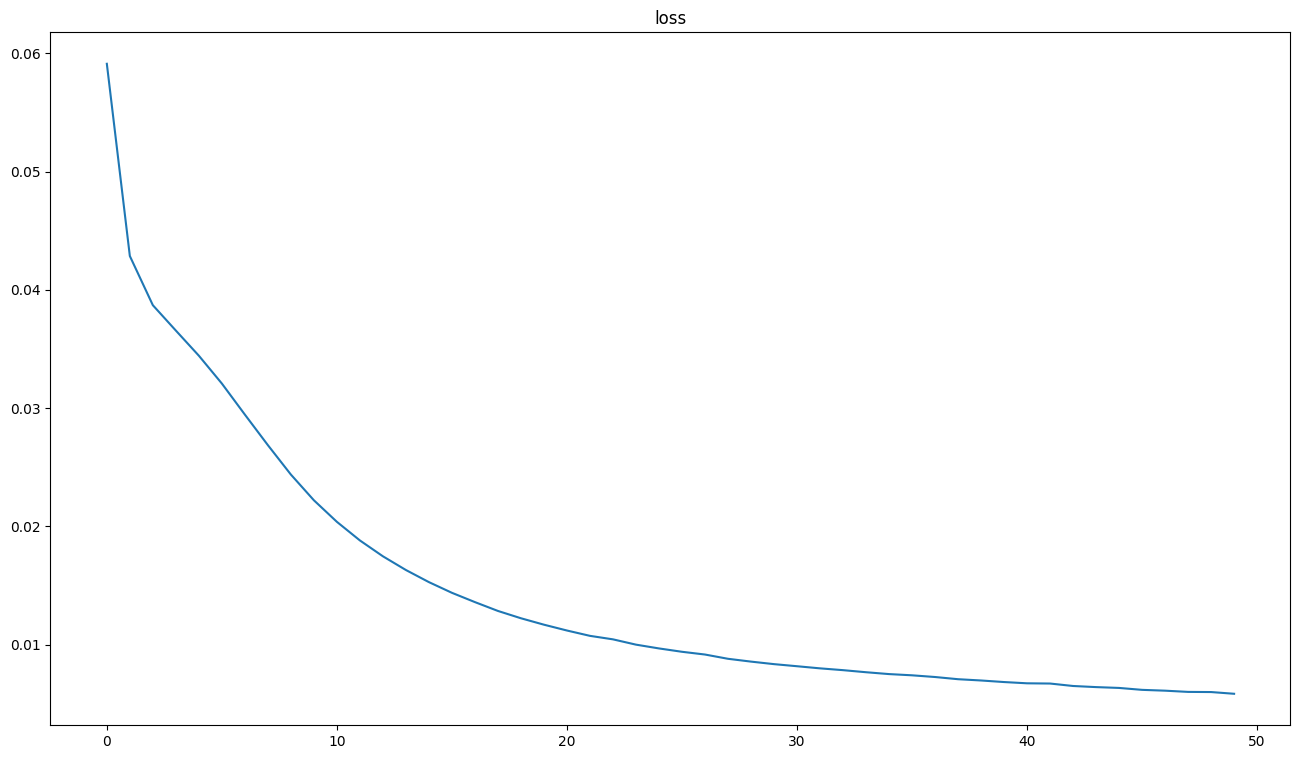

In [13]:
plt.plot(history.history['loss'])
plt.title('loss')
#plt.plot(history.history['mean_squared_error'])
#plt.title('validate loss')
plt.show()

# 2 - Red Neuronal - con Embeddings

In [14]:
emb_n = 30                  #tamanio profundidad de embeddings

in_dias = Input(shape=[1], name = 'dias')
emb_dias = Embedding(7, emb_n)(in_dias)
in_meses = Input(shape=[1], name = 'meses')
emb_meses = Embedding(13, emb_n)(in_meses)
in_anios = Input(shape=[1], name = 'anios')
emb_anios = Embedding(6, emb_n)(in_anios)

in_cli = Input(shape=[1], name = 'cli')

fe = concatenate([(emb_dias), (emb_meses),(emb_anios)])

x = Flatten()(fe)
x = Dense(dense_n,activation=fun_act)(x)
outp = Dense(1,activation=fun_act)(x)

model = Model(inputs=[in_dias,in_meses,in_anios,in_cli], outputs=outp)

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])

model.summary()

history=model.fit([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data, epochs=EPOCHS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 dias (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 meses (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 anios (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 30)                210       ['dias[0][0]']                
                                                                                              

In [15]:
# evaluamos el modelo
scores = model.evaluate([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data)
print("\n%s: %.4f" % (model.metrics_names[1], scores[1]))

scores = model.evaluate([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']], valid_target)
print("\n%s: %.4f" % (model.metrics_names[1], scores[1]))


32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - MSE: 0.0037

MSE: 0.0037
14/14 [==============================] - 0s 2ms/step - loss: 0.0059 - MSE: 0.0059

MSE: 0.0059


14/14 [==============================] - 0s 2ms/step
440


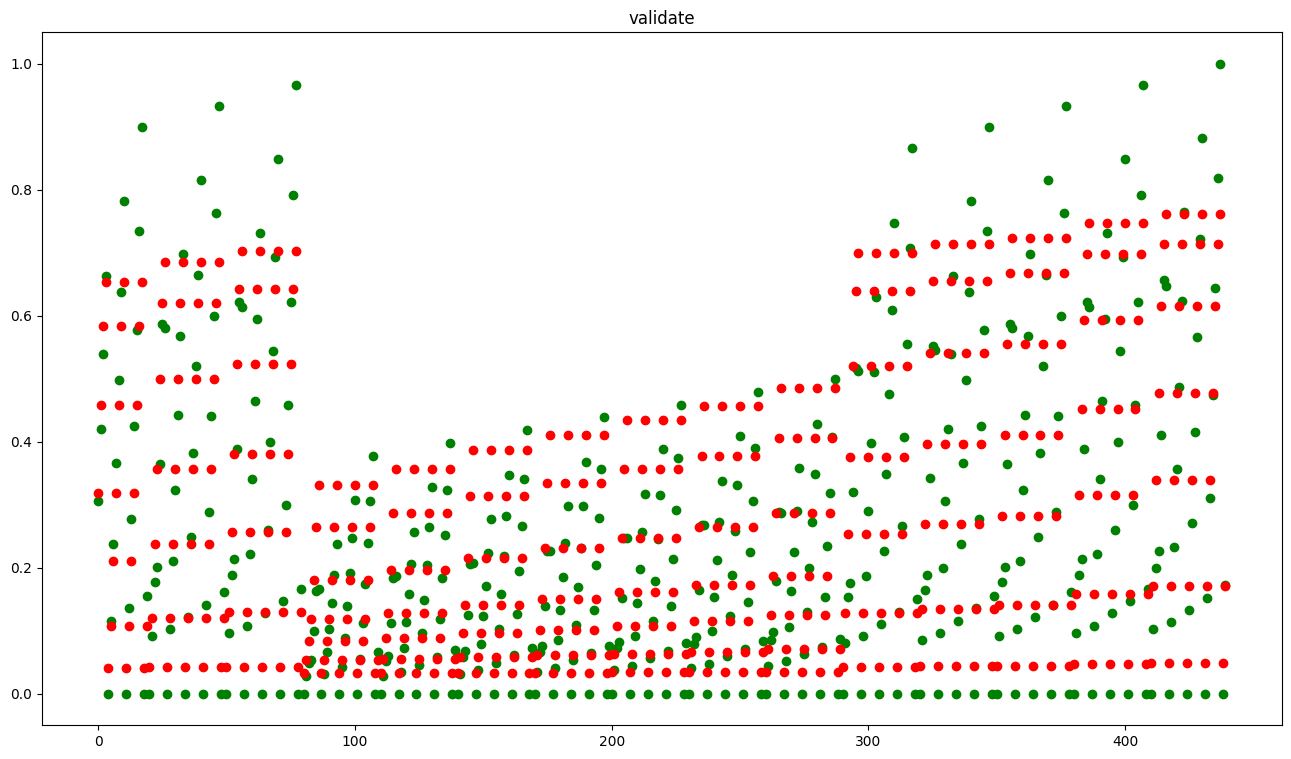

In [16]:
results=model.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

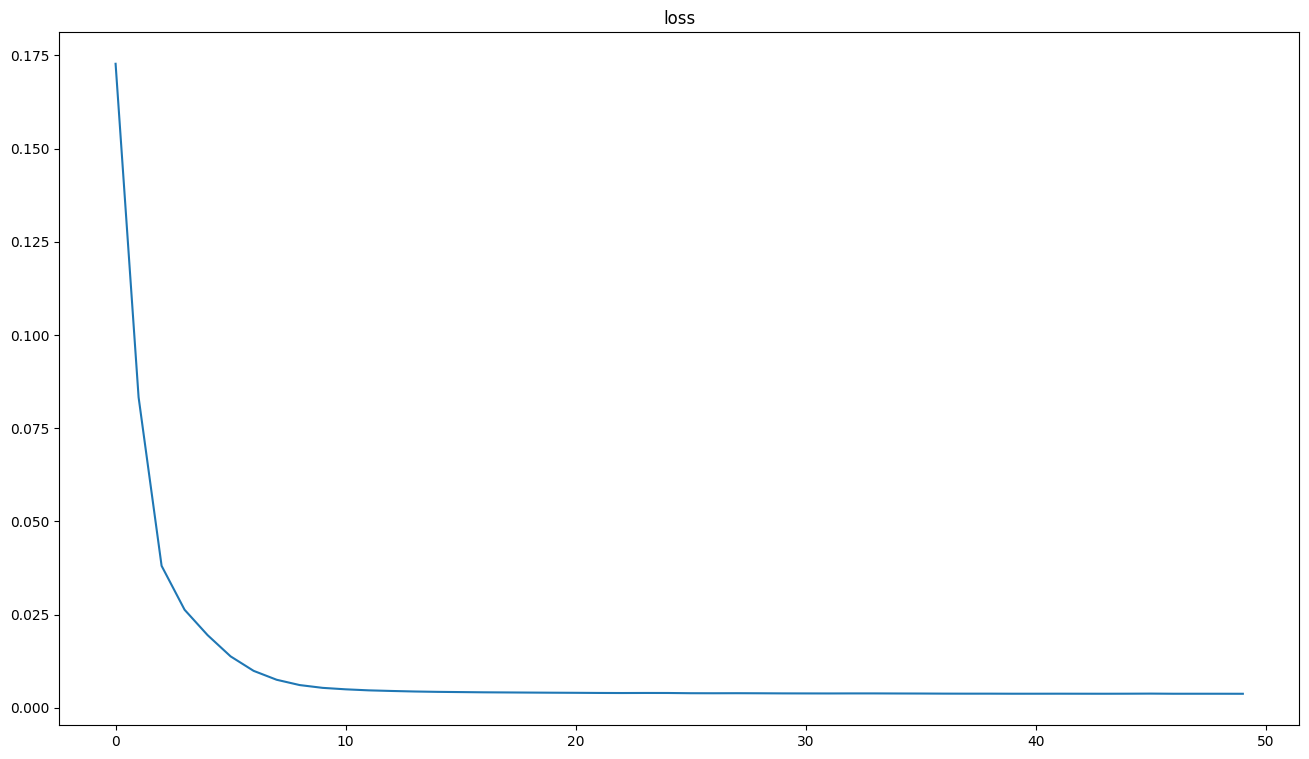

In [17]:
plt.plot(history.history['loss'])
plt.title('loss')
#plt.plot(history.history['mean_squared_error'])
#plt.title('validate loss')
plt.show()

# Comparamos Visualmente

32/32 [==============================] - 0s 2ms/step


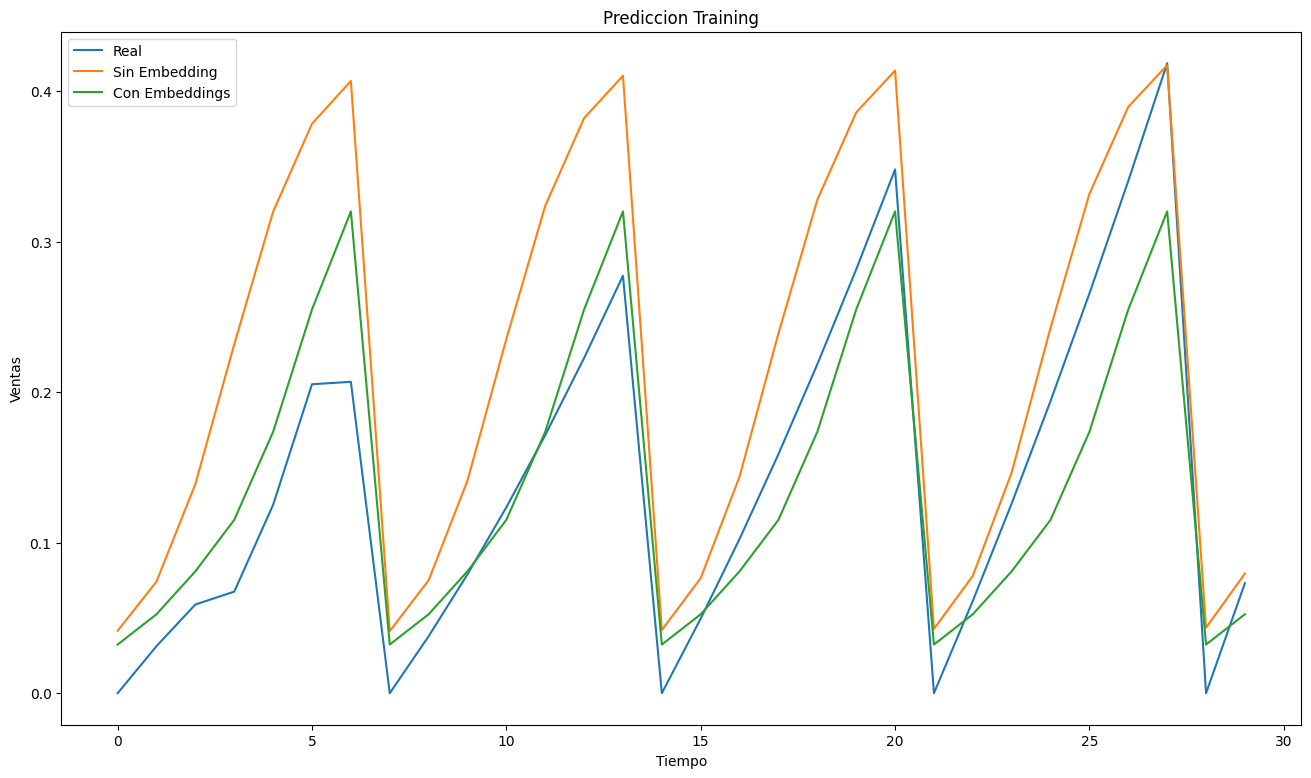

In [18]:
pred0 = model0.predict([training_data])
pred1 = model.predict([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']])

cuantos=30
offset=150
predic_sin=[]
predic_emb=[]
reales=[]
for i in range(0,cuantos):
    predic_sin.append(pred0[i+offset][0])
    predic_emb.append(pred1[i+offset][0])
    reales.append(target_data[i+offset])

Nc = range(0, cuantos)

plt.plot(Nc, reales)
plt.plot(Nc, predic_sin)
plt.plot(Nc, predic_emb)

plt.gca().legend(('Real','Sin Embedding','Con Embeddings'))
#plt.legend(loc='upper left')
plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.title('Prediccion Training')
plt.show()

***NOTA:***

Pareciera que la curva de red con Embeddings se aproxima un poco más a la curva real

14/14 [==============================] - 0s 2ms/step


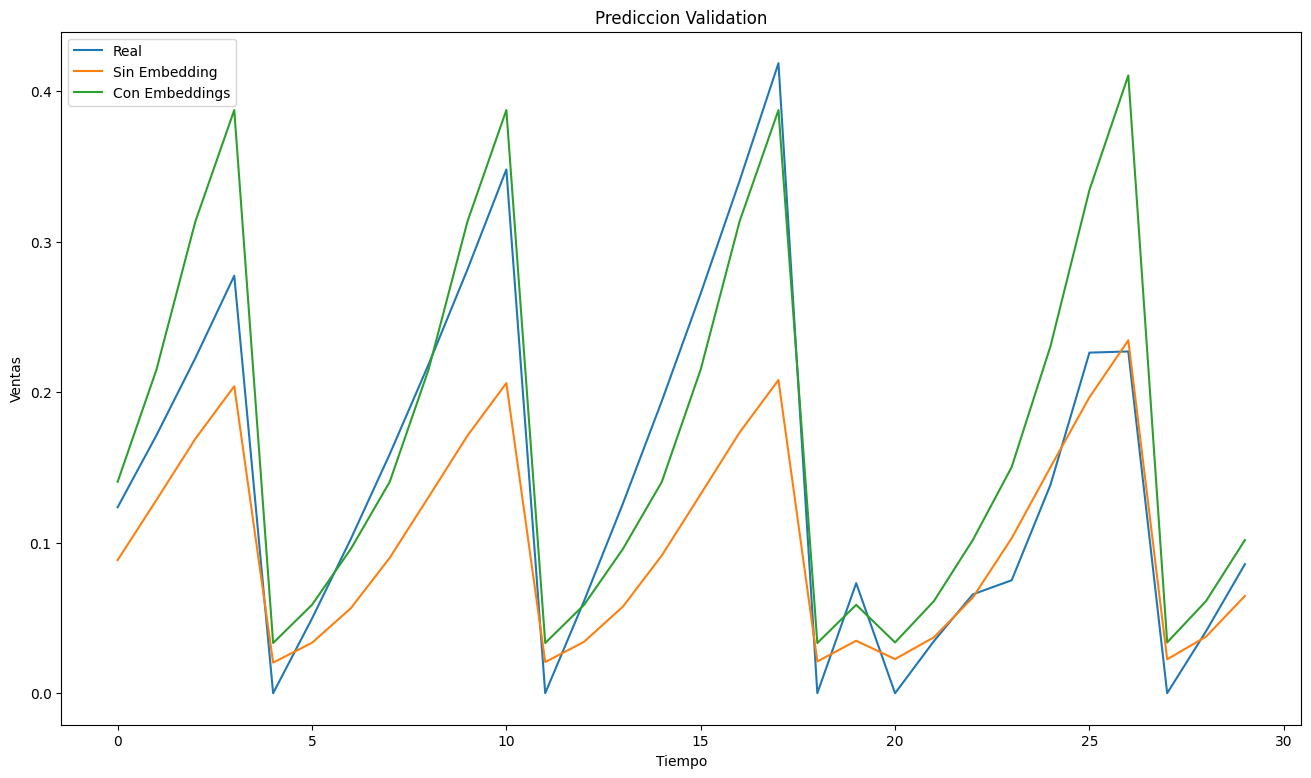

In [19]:
pred0 = model0.predict([valid_data])
pred1 = model.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])

predic_sin=[]
predic_emb=[]
reales=[]
for i in range(0,cuantos):
    predic_sin.append(pred0[i+offset][0])
    predic_emb.append(pred1[i+offset][0])
    reales.append(valid_target[i+1000+offset])

Nc = range(0, cuantos)
plt.plot(Nc, reales)
plt.plot(Nc, predic_sin)
plt.plot(Nc, predic_emb)

plt.gca().legend(('Real','Sin Embedding','Con Embeddings'))

plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.title('Prediccion Validation')
plt.show()

# 3 - Red Neuronal con más capas Sin Embeddings

In [ ]:
model0 = Sequential()
model0.add(Dense(dense_n, input_dim=4, activation=fun_act))
model0.add(Dense(dense_n, activation=fun_act))
model0.add(Dense(1, activation=fun_act))

model0.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])

history=model0.fit(training_data, target_data, epochs=EPOCHS)

Epoch 1/50
32/32 [==============================] - 1s 3ms/step - loss: 0.1661 - MSE: 0.1661
Epoch 2/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0721 - MSE: 0.0721
Epoch 3/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0451 - MSE: 0.0451
Epoch 4/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0392 - MSE: 0.0392
Epoch 5/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0374 - MSE: 0.0374
Epoch 6/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0365 - MSE: 0.0365
Epoch 7/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0357 - MSE: 0.0357
Epoch 8/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0348 - MSE: 0.0348
Epoch 9/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0338 - MSE: 0.0338
Epoch 10/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0327 - MSE: 0.0327
Epoch 11/50
32/32 [==============================] - 0s 3ms/step - lo

In [ ]:
# evaluamos el modelo
scores = model0.evaluate(training_data, target_data)
print("\n%s: %.4f" % (model0.metrics_names[1], scores[1]))

scores = model0.evaluate(valid_data, valid_target)
print("\n%s: %.4f" % (model0.metrics_names[1], scores[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.0058 - MSE: 0.0058

MSE: 0.0058
14/14 [==============================] - 0s 2ms/step - loss: 0.0133 - MSE: 0.0133

MSE: 0.0133


14/14 [==============================] - 0s 2ms/step
440


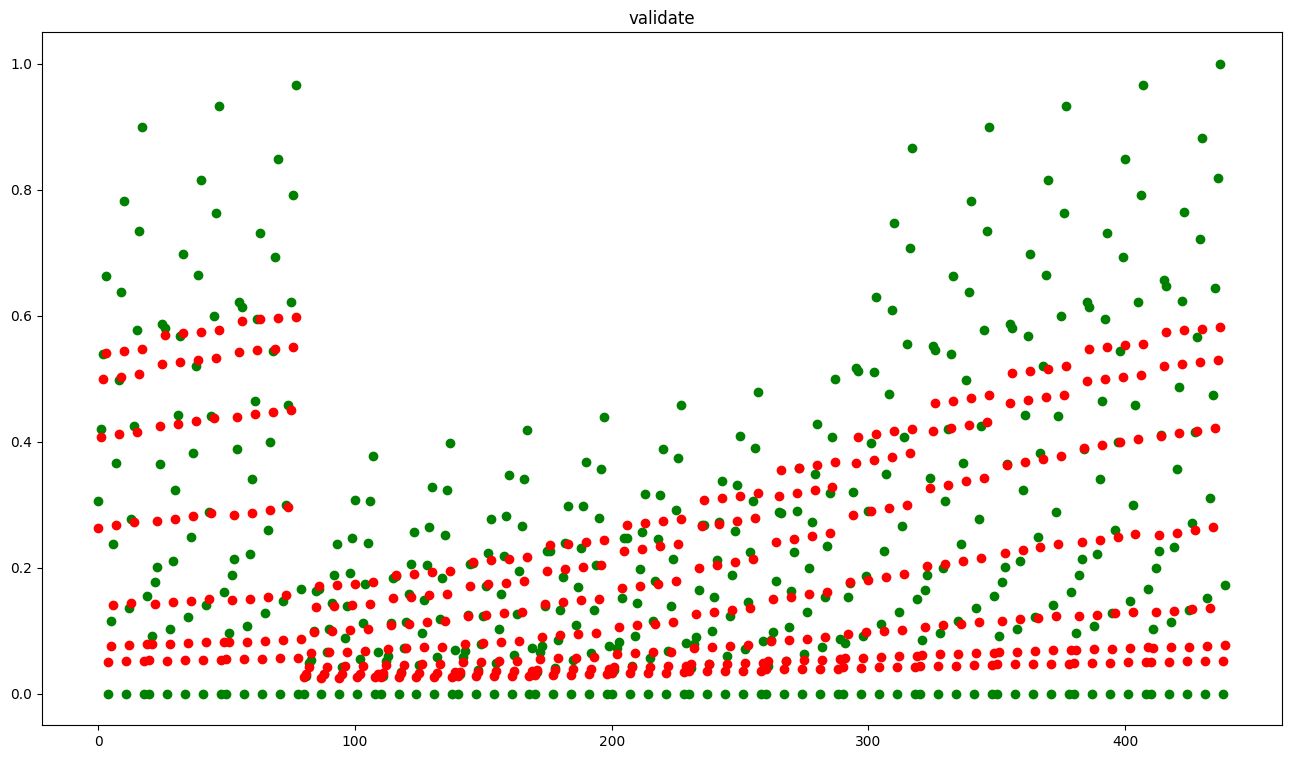

In [ ]:
results=model0.predict(valid_data)
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

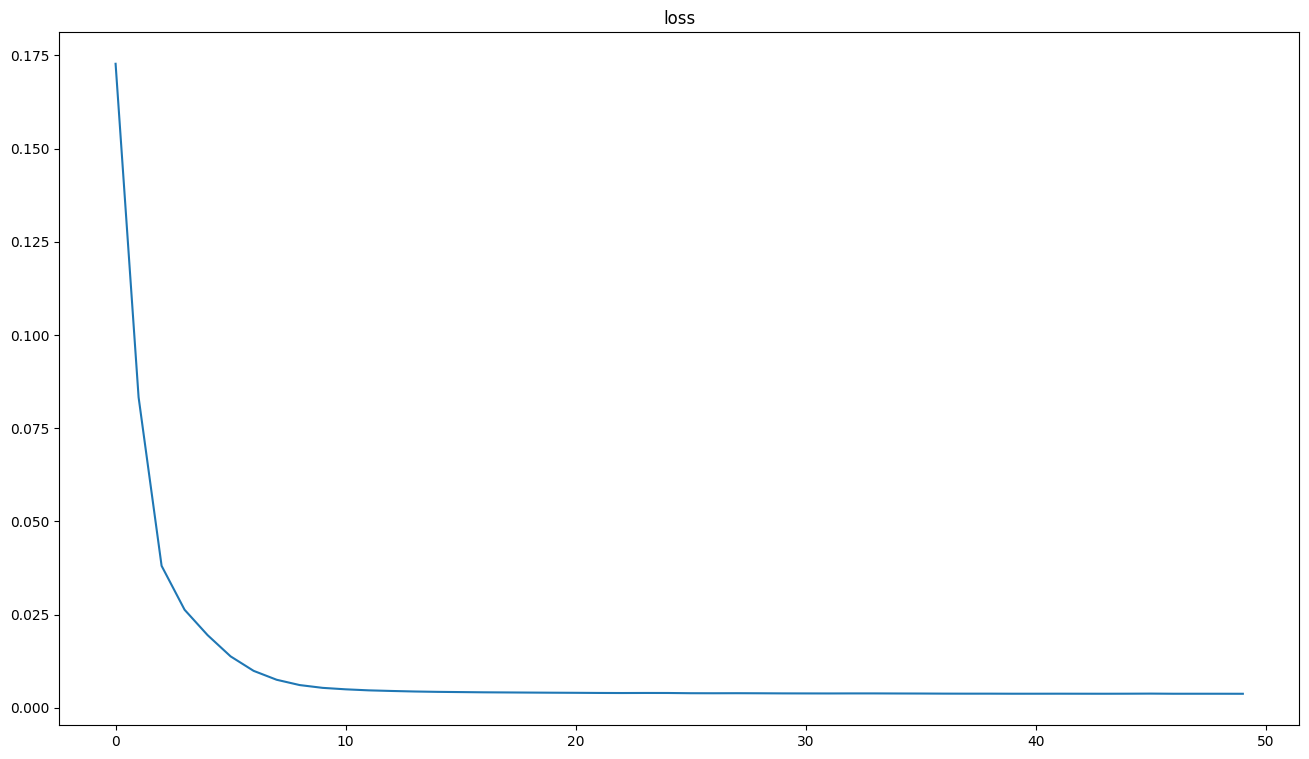

In [20]:
plt.plot(history.history['loss'])
plt.title('loss')
#plt.plot(history.history['mean_squared_error'])
#plt.title('validate loss')
plt.show()

# 4 - Red Neuronal con Embedings y 2 capas

In [21]:
emb_n = 30            #tamaño profundidad de embeddings

in_dias = Input(shape=[1], name = 'dias')
emb_dias = Embedding(7, emb_n)(in_dias)
in_meses = Input(shape=[1], name = 'meses')
emb_meses = Embedding(13, emb_n)(in_meses)
in_anios = Input(shape=[1], name = 'anios')
emb_anios = Embedding(6, emb_n)(in_anios)

in_cli = Input(shape=[1], name = 'cli')

fe = concatenate([(emb_dias), (emb_meses),(emb_anios)])

x = Flatten()(fe)
x = Dense(dense_n,activation=fun_act)(x)

x2 = Dense(dense_n,activation=fun_act)(x)

outp = Dense(1,activation=fun_act)(x2)
model = Model(inputs=[in_dias,in_meses,in_anios,in_cli], outputs=outp)

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])

history=model.fit([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data, epochs=EPOCHS)

Epoch 1/50
32/32 [==============================] - 2s 19ms/step - loss: 0.0363 - MSE: 0.0363
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0343 - MSE: 0.0343
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0300 - MSE: 0.0300
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0216 - MSE: 0.0216
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0128 - MSE: 0.0128
Epoch 6/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0080 - MSE: 0.0080
Epoch 7/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0061 - MSE: 0.0061
Epoch 8/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0055 - MSE: 0.0055
Epoch 9/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0052 - MSE: 0.0052
Epoch 10/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0050 - MSE: 0.0050
Epoch 11/50
32/32 [==============================] - 0s 4ms/step - l

In [22]:
# evaluamos el modelo
scores = model.evaluate([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data)
print("\n%s: %.4f" % (model.metrics_names[1], scores[1]))

scores = model.evaluate([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']], valid_target)
print("\n%s: %.4f" % (model.metrics_names[1], scores[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.0038 - MSE: 0.0038

MSE: 0.0038
14/14 [==============================] - 0s 2ms/step - loss: 0.0051 - MSE: 0.0051

MSE: 0.0051


14/14 [==============================] - 0s 2ms/step
440


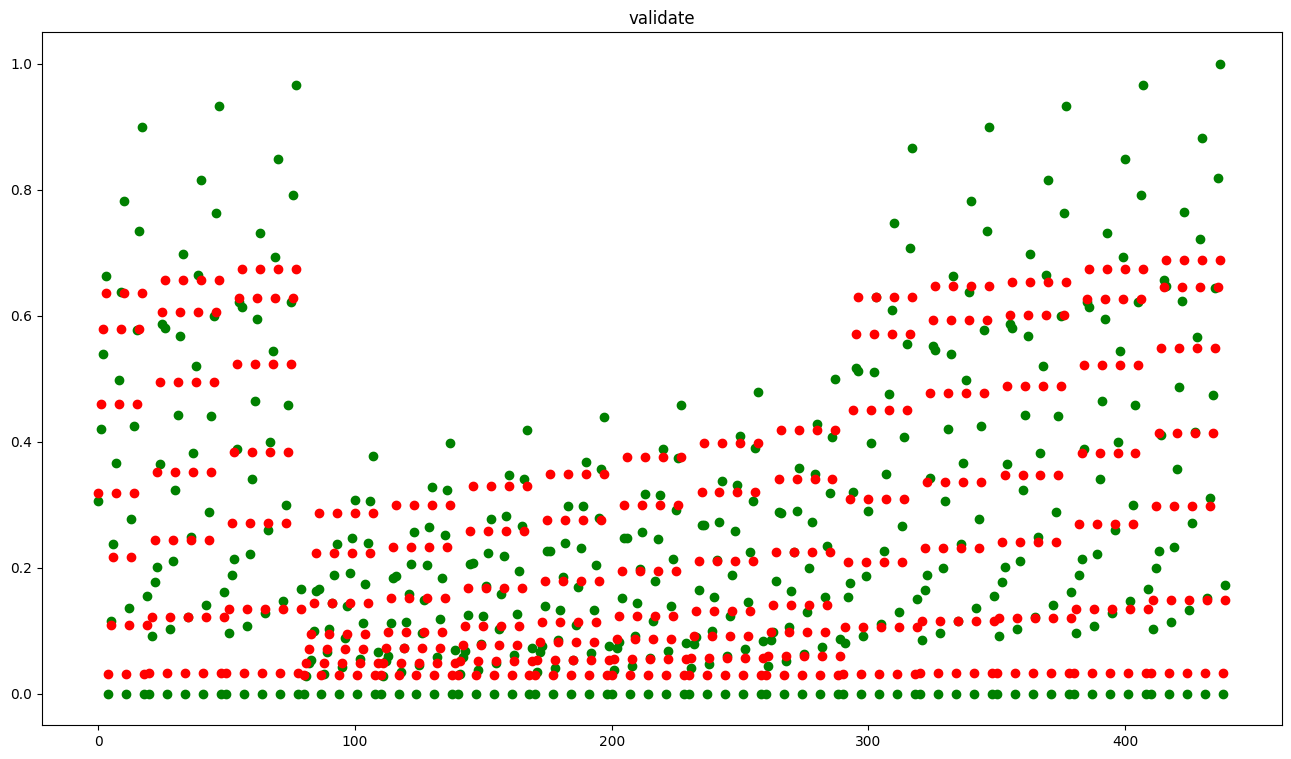

In [23]:
results=model.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

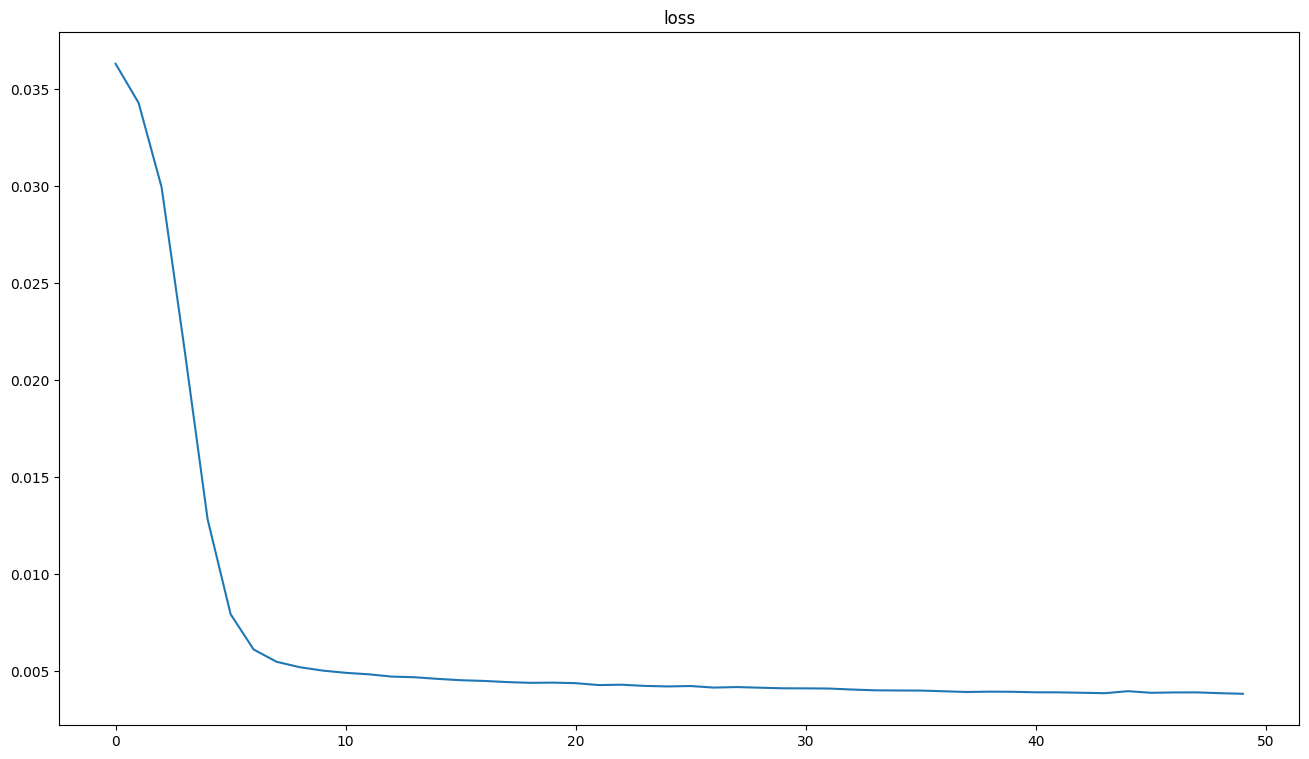

In [24]:
plt.plot(history.history['loss'])
plt.title('loss')
#plt.plot(history.history['mean_squared_error'])
#plt.title('validate loss')
plt.show()

# Comparamos NN con 2 capas y NN con Embedings 2 capas

14/14 [==============================] - 0s 2ms/step


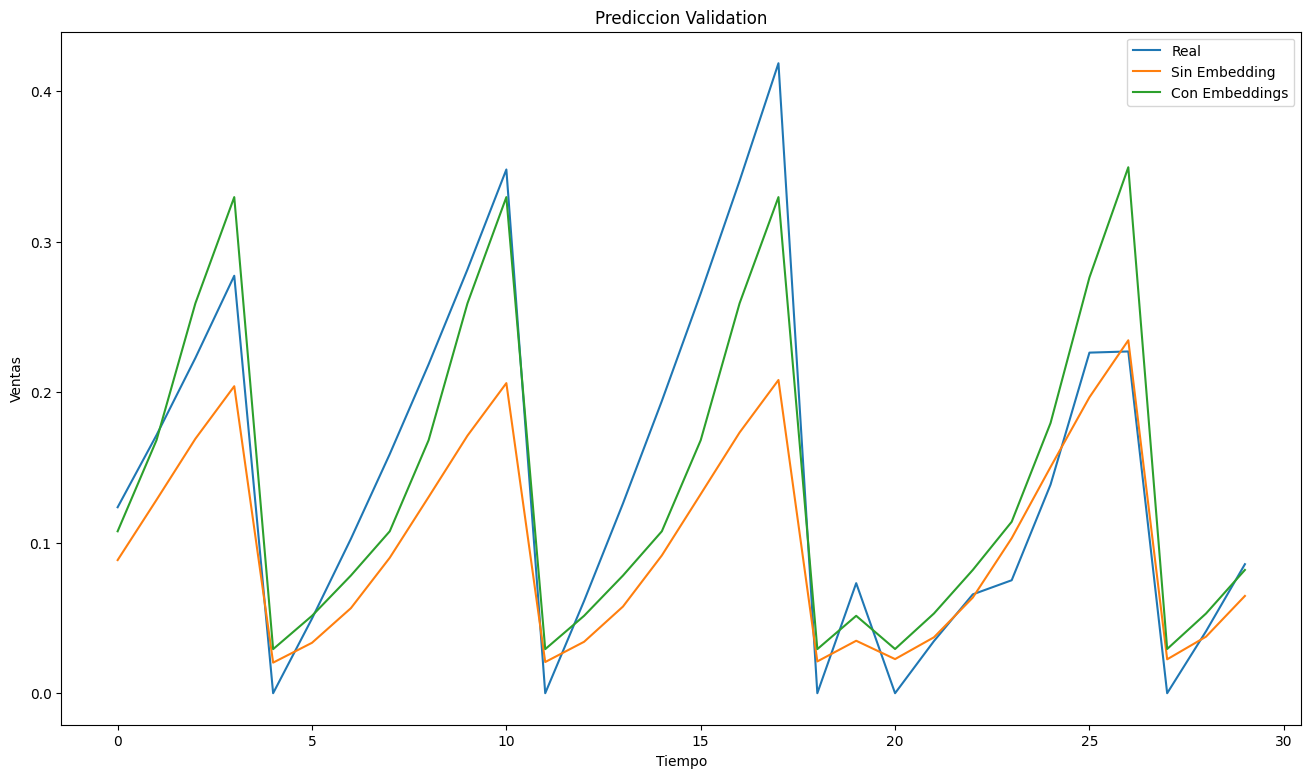

In [25]:
pred0 = model0.predict([valid_data])
pred1 = model.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])

predic_sin=[]
predic_emb=[]
reales=[]
for i in range(0,cuantos):
    predic_sin.append(pred0[i+offset][0])
    predic_emb.append(pred1[i+offset][0])
    reales.append(valid_target[i+1000+offset])

Nc = range(0, cuantos)
plt.plot(Nc, reales)
plt.plot(Nc, predic_sin)
plt.plot(Nc, predic_emb)

plt.gca().legend(('Real','Sin Embedding','Con Embeddings'))

plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.title('Prediccion Validation')
plt.show()

# 5 - LSTM con Embeddings

In [26]:
emb_n = 30#tamanio profundidad de embeddings

in_dias = Input(shape=[1], name = 'dias')
emb_dias = Embedding(7, emb_n)(in_dias)
in_meses = Input(shape=[1], name = 'meses')
emb_meses = Embedding(13, emb_n)(in_meses)
in_anios = Input(shape=[1], name = 'anios')
emb_anios = Embedding(6, emb_n)(in_anios)

in_cli = Input(shape=[1], name = 'cli')

x = concatenate([(emb_dias), (emb_meses),(emb_anios)])

#x = Flatten()(fe)

x = LSTM(units = 25, return_sequences = True, input_shape = (5, 10))(x)
x = Dropout(0.2)(x)
x = LSTM(units = 25, return_sequences = False, input_shape = (5, 10))(x)
x = Dropout(0.2)(x)

x = Dense(dense_n,activation='relu')(x)
x = Dropout(0.2)(x)

outp = Dense(1,activation='sigmoid')(x)

#outp = Dense(1,activation=fun_act)(x)
model3 = Model(inputs=[in_dias,in_meses,in_anios,in_cli], outputs=outp)

model3.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])

model3.summary()

history=model3.fit([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data, epochs=EPOCHS)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 dias (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 meses (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 anios (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 1, 30)                210       ['dias[0][0]']                
                                                                                            

In [27]:
# evaluamos el modelo
scores = model3.evaluate([training_data['dia'],training_data['mes'],training_data['anio'],training_data['clientes']], target_data)
print("\n%s: %.4f" % (model3.metrics_names[1], scores[1]))

scores = model3.evaluate([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']], valid_target)
print("\n%s: %.4f" % (model3.metrics_names[1], scores[1]))

32/32 [==============================] - 1s 3ms/step - loss: 0.0035 - MSE: 0.0035

MSE: 0.0035
14/14 [==============================] - 0s 3ms/step - loss: 0.0045 - MSE: 0.0045

MSE: 0.0045


14/14 [==============================] - 1s 3ms/step
440


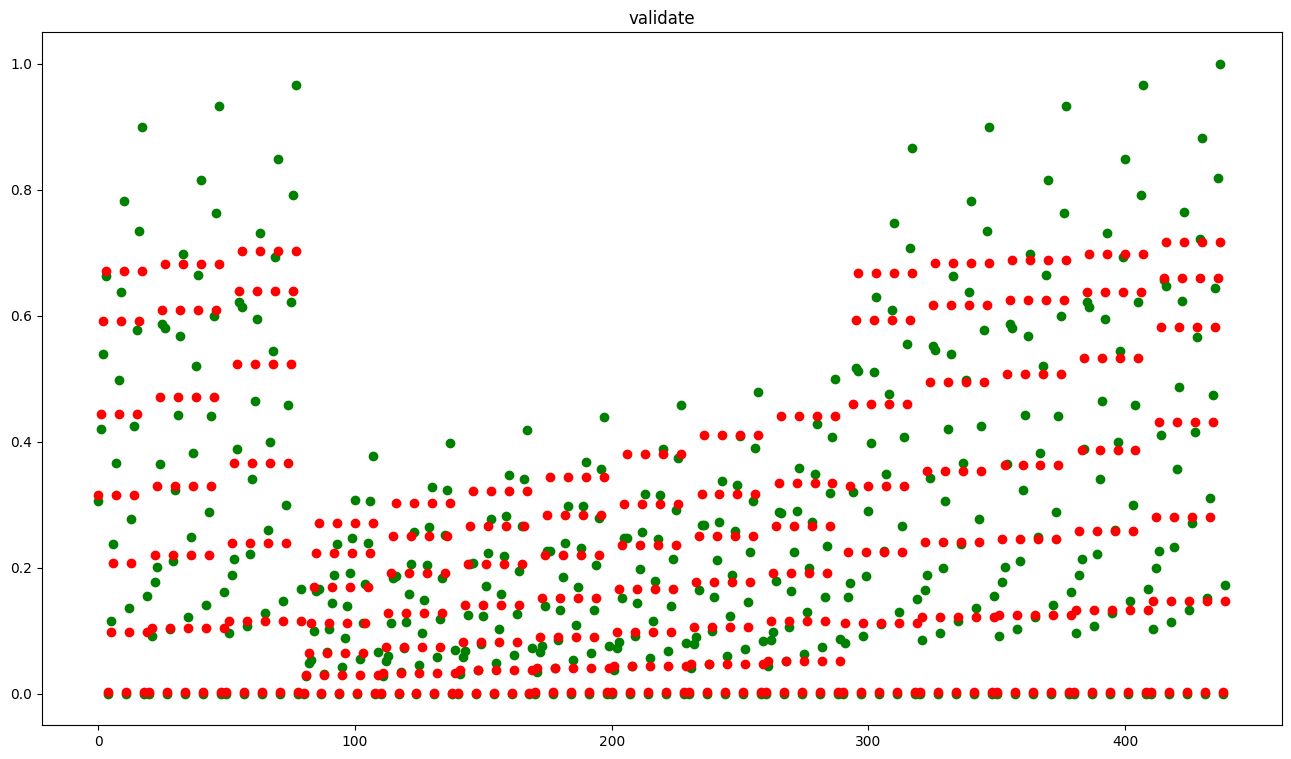

In [28]:
results=model3.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

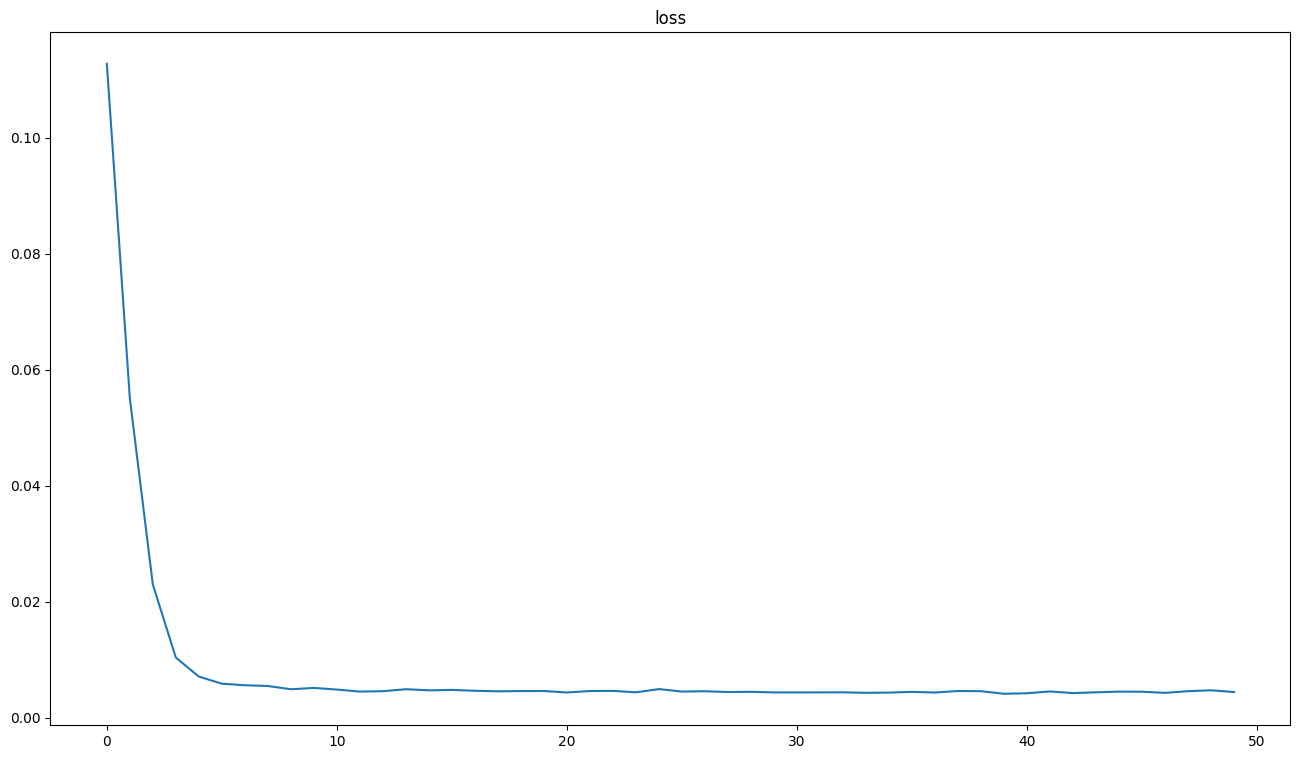

In [29]:
plt.plot(history.history['loss'])
plt.title('loss')
#plt.plot(history.history['mean_squared_error'])
#plt.title('validate loss')
plt.show()

# Comparamos la NN sin EMbedding con la LSTM con Embeddings

14/14 [==============================] - 0s 2ms/step


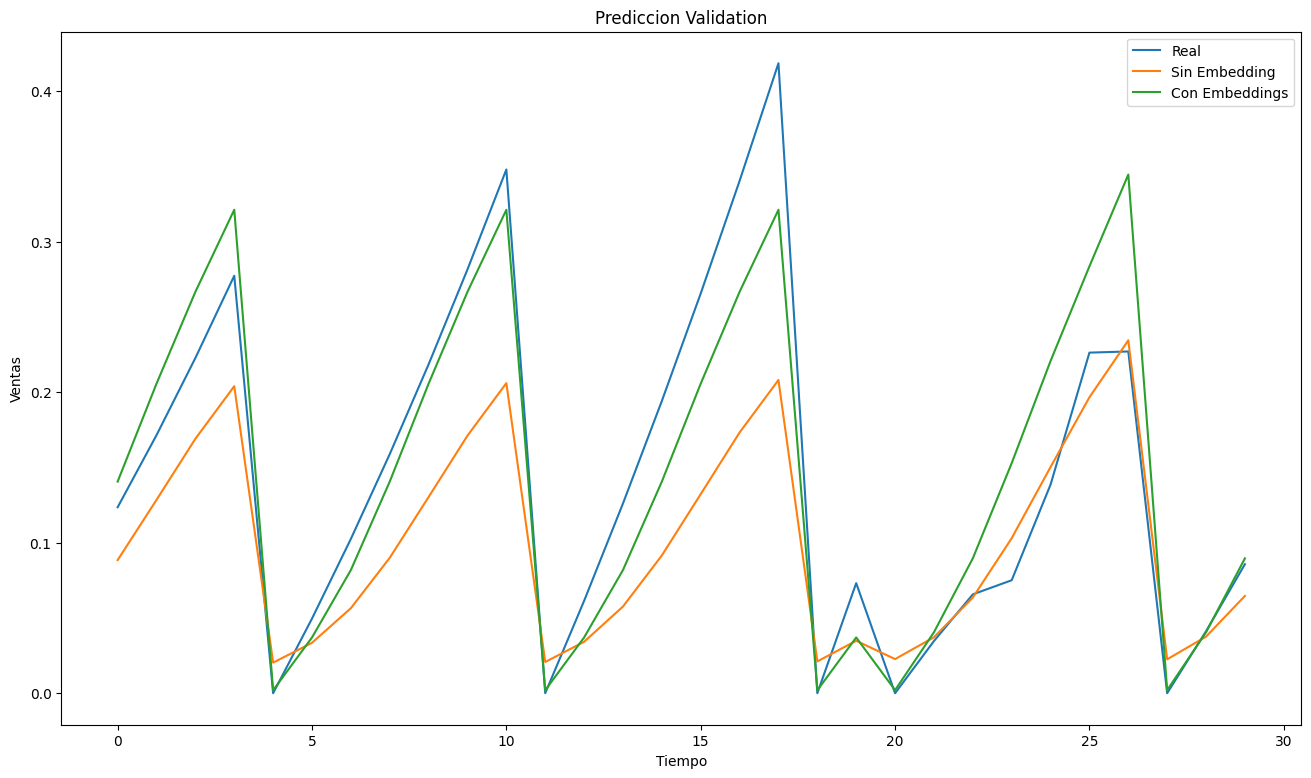

In [30]:
pred0 = model0.predict([valid_data])
pred1 = model3.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])

predic_sin=[]
predic_emb=[]
reales=[]
for i in range(0,cuantos):
    predic_sin.append(pred0[i+offset][0])
    predic_emb.append(pred1[i+offset][0])
    reales.append(valid_target[i+1000+offset])

Nc = range(0, cuantos)
plt.plot(Nc, reales)
plt.plot(Nc, predic_sin)
plt.plot(Nc, predic_emb)

plt.gca().legend(('Real','Sin Embedding','Con Embeddings'))

plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.title('Prediccion Validation')
plt.show()

# Comparamos la red con Embeddings y la LSTM con Embeddings

14/14 [==============================] - 0s 2ms/step


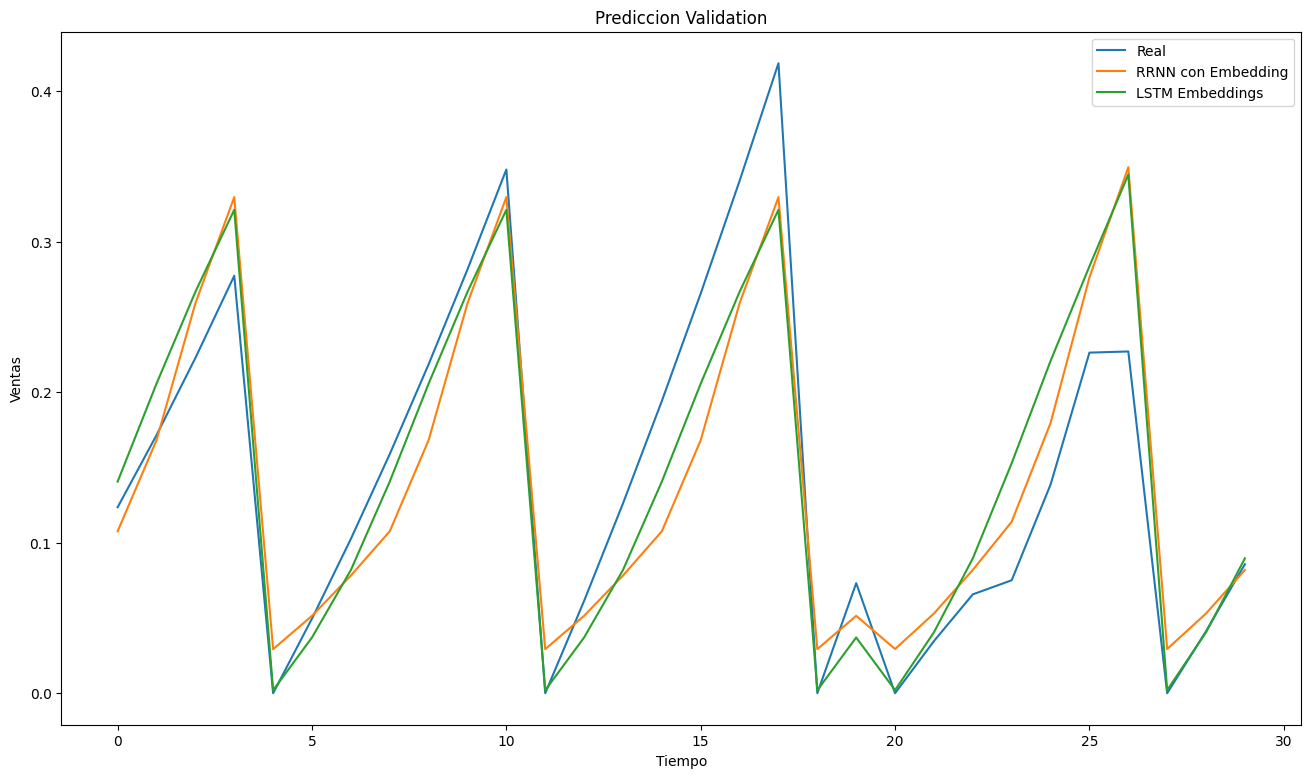

In [31]:
pred0 = model.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])
pred1 = model3.predict([valid_data['dia'],valid_data['mes'],valid_data['anio'],valid_data['clientes']])

predic_sin=[]
predic_emb=[]
reales=[]
for i in range(0,cuantos):
    predic_sin.append(pred0[i+offset][0])
    predic_emb.append(pred1[i+offset][0])
    reales.append(valid_target[i+1000+offset])

Nc = range(0, cuantos)
plt.plot(Nc, reales)
plt.plot(Nc, predic_sin)
plt.plot(Nc, predic_emb)

plt.gca().legend(('Real','RRNN con Embedding','LSTM Embeddings'))

plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.title('Prediccion Validation')
plt.show()

Esta última está muy parejo!

# Conclusión

- Si bien se nota una mejora con el uso de Embeddings, al menos para este ejemplo inventado no parece haber tanta diferencia con el uso de redes neuronales "normales" (MLP) y valores categóricos.